In [6]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPooling2D, SeparableConv2D, Dense, Concatenate, BatchNormalization, GlobalAveragePooling2D, Add, AveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os

In [4]:
def load_dataset(dataset_path, image_size=(120, 120)):
    images = []
    labels = []
    class_names = ['Artificial', 'Natural']

    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        
        for file in os.listdir(class_dir):
            if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg'):
                img_path = os.path.join(class_dir, file)
                img = load_img(img_path, target_size=image_size)
                img_array = img_to_array(img)
                img_array /= 255.0
                images.append(img_array)
                
                # Append the label to the labels list as a one-hot encoded array
                label = to_categorical(class_names.index(class_name), num_classes=2)
                labels.append(np.expand_dims(np.stack([label, 1 - label]), axis=0))  # Stack label and 1-label

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Example usage:
dataset_path = 'Dataset_7'
images, labels = load_dataset(dataset_path)

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into a training set and a hold-out test set
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.25, random_state=42
)

In [6]:
# Define the number of splits for k-fold cross-validation
k = 4
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [7]:
def create_head_model():
    input_layer = Input(shape=(120, 120, 3))
    # First block
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(input_layer)
    x = ReLU()(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = ReLU()(x)
    
    x1 = x
    x1 = Conv2D(128, (1, 1), strides=(2, 2))(x1)

    # Second block
    x = SeparableConv2D(128, (3, 3), padding='same')(x)
    x = ReLU()(x)
    x = SeparableConv2D(128, (3, 3), padding='same')(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    x = tf.add(x, x1)

    x2 = x
    x2 = Conv2D(256, (1, 1), strides=(2, 2))(x2)

    # Third block
    x = SeparableConv2D(256, (3, 3), padding='same')(x)
    x = ReLU()(x)
    x = SeparableConv2D(256, (3, 3), padding='same')(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    x = tf.add(x, x2)

    x3 = x
    x3 = Conv2D(728, (1, 1), strides=(2, 2))(x3)

    # Fourth block
    x = SeparableConv2D(728, (3, 3), padding='same')(x)
    x = ReLU()(x)
    x = SeparableConv2D(728, (3, 3), padding='same')(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    x = tf.add(x, x3)
    
    # Middle Flow (repeated block)
    for _ in range(2):
        block_input = x
        x = ReLU()(x)
        x = SeparableConv2D(728, (3, 3), padding='same')(x)
        x = ReLU()(x)
        x = SeparableConv2D(728, (3, 3), padding='same')(x)
        x = ReLU()(x)
        x = SeparableConv2D(728, (3, 3), padding='same')(x)
        # Add the block_input (residual connection), not visible in the diagram
        x = tf.add(x, block_input)
    
    x = ReLU()(x)
    head_model = Model(inputs=input_layer, outputs=x)
    return head_model

In [8]:
def create_ensemble_model(head_model, num_submodels):
    inputs = Input(shape=(120, 120, 3))
    head_outputs = head_model(inputs)

    submodel_outputs = []
    for i in range(num_submodels):
        x = SeparableConv2D(4, (3, 3), strides=(2, 2), padding='same')(head_outputs)
        x = ReLU()(x)
        x = SeparableConv2D(16, (3, 3), strides=(2, 2), padding='same')(x)
        x = ReLU()(x)
        x = Dense(1, activation='sigmoid', name=f'output_{i}')(x)  # Sigmoid activation for binary classification
        submodel_outputs.append(x)
    
    if len(submodel_outputs) > 1:
        ensemble_outputs = Concatenate()(submodel_outputs)
    else:
        ensemble_outputs = submodel_outputs[0]

    ensemble_model = Model(inputs=inputs, outputs=ensemble_outputs)
    return ensemble_model

In [10]:
# Instantiate the head model
head_model = create_head_model()

# Define the number of submodels in the ensemble
num_submodels = 2  # Replace with the number of submodels you have

# Instantiate the ensemble model
ensemble_model = create_ensemble_model(head_model, num_submodels)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# K-fold Cross Validation model evaluation

ensemble_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

kf = KFold(n_splits=4, shuffle=True, random_state=42)

fold_no = 1
for train_index, val_index in kf.split(train_images):
    smaller_train_images, val_images = train_images[train_index], train_images[val_index]
    smaller_train_labels, val_labels = train_labels[train_index], train_labels[val_index]
    print(f'Training for fold {fold_no} ...')

    history = ensemble_model.fit(
        smaller_train_images, smaller_train_labels,
        batch_size=128,
        epochs=100,
        validation_data=(val_images, val_labels)
    )

    fold_no += 1

Training for fold 1 ...
Epoch 1/100
28/28 [==============================] - 59s 2s/step - loss: 0.6928 - accuracy: 0.5908 - val_loss: 0.6921 - val_accuracy: 0.6342
Epoch 2/100
28/28 [==============================] - 58s 2s/step - loss: 0.6909 - accuracy: 0.6447 - val_loss: 0.6880 - val_accuracy: 0.6631
Epoch 3/100
28/28 [==============================] - 58s 2s/step - loss: 0.6814 - accuracy: 0.6494 - val_loss: 0.6665 - val_accuracy: 0.6633
Epoch 4/100
28/28 [==============================] - 57s 2s/step - loss: 0.6607 - accuracy: 0.6520 - val_loss: 0.6470 - val_accuracy: 0.6654
Epoch 5/100
28/28 [==============================] - 57s 2s/step - loss: 0.6500 - accuracy: 0.6527 - val_loss: 0.6387 - val_accuracy: 0.6650
Epoch 6/100
28/28 [==============================] - 57s 2s/step - loss: 0.6457 - accuracy: 0.6524 - val_loss: 0.6365 - val_accuracy: 0.6657
Epoch 7/100
28/28 [==============================] - 58s 2s/step - loss: 0.6452 - accuracy: 0.6526 - val_loss: 0.6348 - val_accura

In [3]:
ensemble_model.save('ensemble_model.h5')
ensemble_model.evaluate(test_images, test_labels)

NameError: name 'ensemble_model' is not defined

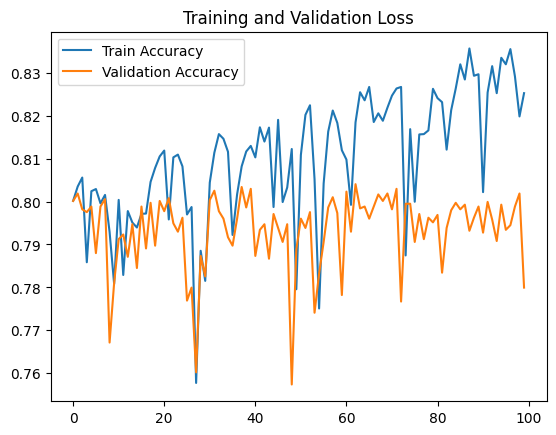

In [18]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [2]:
from sklearn.metrics import classification_report

# Make predictions on the test set
predictions = ensemble_model.predict(test_images)

# Convert predictions to binary labels
binary_predictions = (predictions > 0.5).astype(int)

# Generate the classification report
report = classification_report(test_labels[:, 0, 0], binary_predictions[:, 0, 0])

print(report)


NameError: name 'ensemble_model' is not defined

In [1]:
print(ensemble_model.predict(test_images[0:1]))

NameError: name 'ensemble_model' is not defined

In [4]:
from keras.models import load_model
model = load_model('ensemble_model.h5')

In [17]:
image = load_img('C:/Vijay/Capstone/NareshDataset/Nylon/140/im_2.png', target_size=(120, 120))
img_array = img_to_array(image)
img_array /= 255.0
img_array = np.array(img_array)
preds = model.predict(img_array.reshape(1, 120, 120, 3))
preds = (preds > 0.5).astype(int)     
preds                             #[[1 0][0 1]] - Artificial       [[0 1][1 0]] - Natural

1/1 [==============================] - 0s 25ms/step


array([[[[1, 0],
         [0, 1]],

        [[1, 0],
         [0, 1]]]])